# Federated Learning Demonstration - Experiment Code and Analysis

This notebook provides a demonstration of federated learning experiments using two algorithms: FedLEO and FedAsyn. It investigates how key parameters such as global rounds, local epochs, and batch size affect model accuracy on two datasets: CIFAR10 and EuroSAT.

The code is intended to showcase how to run federated learning experiments and analyze the results using visualizations.

---

## What This Notebook Covers:
- Runs federated training for different combinations of models, datasets, and FL parameters.
- Compares performance between FedLEO and FedAsyn.
- Analyzes the impact of batch size, local training epochs, and data distribution (IID vs non-IID).
- Includes visualizations such as line plots, heatmaps, and boxplots to highlight performance trends.
- Saves results in a CSV file for further analysis.

---

## About This File:
This is a demonstration notebook. The plots displayed above are based on a sample file named `demo_accuracy_results.csv`, created by running selected configurations in smaller batches.

You may run the complete experiment loop at the end of the notebook. However:

**Note**: Running the full loop takes a significant amount of time and computational resources. It is recommended to run the full loop **only when you have sufficient computational power** and are ready to execute all experiments **at once**. For initial testing, running smaller batches or single configurations is recommended.

---

## Learning Outcome:
By the end of this notebook, you will understand how different federated learning settings influence model performance and which configurations are most effective for each dataset and algorithm.


In [ ]:
# Import necessary libraries
import os  # For interacting with the operating system (e.g., file paths)
import subprocess  # For running external scripts or shell commands
import pickle  # For saving/loading Python objects in binary format
import matplotlib.pyplot as plt  # For creating plots and visualizations
import numpy as np  # For numerical operations and array handling
import pandas as pd  # For data manipulation and analysis using DataFrames
import seaborn as sns  # For statistical data visualization (built on matplotlib)

In [21]:
# Load the CSV file
df = pd.read_csv("demo_accuracy_results.csv", sep="\t")

# Clean strings to remove invisible differences
df["Model"] = df["Model"].str.strip()
df["Dataset"] = df["Dataset"].str.strip()
df["Model Name"] = df["Model Name"].str.replace("fedasync", "fedasyn", case=False)
df["Model_Name_Clean"] = df["Model Name"].str.replace("fedasync", "fedasyn", case=False)

# Show first few rows
df.head()

,Model Name,Model,Dataset,Epochs,Local Epochs,Local Batch Size,Learning Rate,Optimizer,IID,Accuracy,Model_Name_Clean
0,fedasyn for eurosat,cnn,eurosat,2,10,8,0.01,sgd,0,0.138519,fedasyn for eurosat
1,fedasyn for eurosat,cnn,eurosat,2,10,20,0.01,sgd,0,0.143333,fedasyn for eurosat
2,fedasyn for eurosat,cnn,eurosat,2,10,32,0.01,sgd,0,0.147778,fedasyn for eurosat
3,fedasyn for eurosat,cnn,eurosat,2,20,8,0.01,sgd,0,0.185741,fedasyn for eurosat
4,fedasyn for eurosat,cnn,eurosat,2,20,20,0.01,sgd,0,0.111481,fedasyn for eurosat


In [10]:
# Re-check unique combinations
unique_combinations = df[["Model", "Dataset"]].drop_duplicates()

print("Unique Model-Dataset combinations:")
print(unique_combinations)
print(f"\nTotal unique combinations: {len(unique_combinations)}")


Unique Model-Dataset combinations:
       Model  Dataset
0        cnn  eurosat
18  resnet18  eurosat
36       cnn    cifar

Total unique combinations: 3


## Average Accuracy by Model

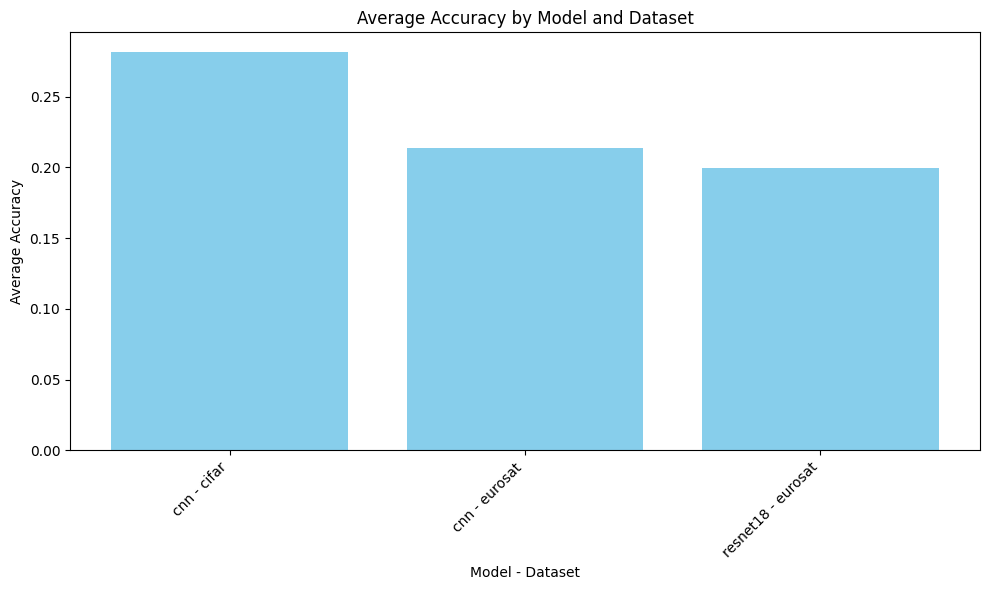

In [11]:
# Group and calculate mean accuracy
model_accuracy = df.groupby(['Model', 'Dataset'])['Accuracy'].mean().reset_index()

# Combine Model and Dataset into a single label for x-axis
model_accuracy['Model_Dataset'] = model_accuracy['Model'] + " - " + model_accuracy['Dataset']

# Plot
plt.figure(figsize=(10, 6))
plt.bar(model_accuracy['Model_Dataset'], model_accuracy['Accuracy'], color='skyblue')
plt.title('Average Accuracy by Model and Dataset')
plt.xlabel('Model - Dataset')
plt.ylabel('Average Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Effect of Global Rounds

### Line Plot – Accuracy vs Global Rounds (Epochs)

This plot shows that more global training rounds lead to better accuracy. FedLEO performs better than FedAsyn as rounds increase. Training for 10 rounds gives the best results.

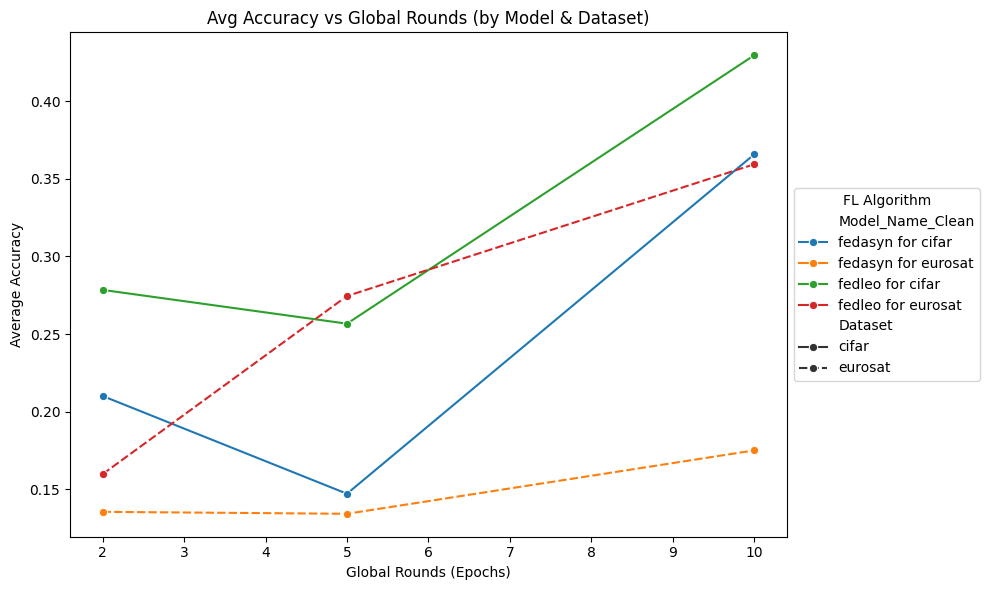

In [12]:
df_epochs = df.groupby(["Epochs", "Model_Name_Clean", "Dataset"])["Accuracy"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_epochs, x="Epochs", y="Accuracy", hue="Model_Name_Clean", style="Dataset", marker="o")
plt.title("Avg Accuracy vs Global Rounds (by Model & Dataset)")
plt.xlabel("Global Rounds (Epochs)")
plt.ylabel("Average Accuracy")
plt.legend(title="FL Algorithm", loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

### Accuracy vs Local Epochs (Batch Sizes: 32, 20, 8)

These three plots show how increasing the number of local training epochs affects model accuracy for different batch sizes.

- Batch Size = 32: Accuracy improves as epochs increase, with FedLEO showing consistent gains.

- Batch Size = 20: Similar trend is observed, but FedAsyn's performance is more unstable.

- Batch Size = 8: Best results overall. Both algorithms improve with more epochs, and FedLEO again performs more reliably.

This confirms that more local training generally leads to better accuracy, especially with smaller batch sizes.

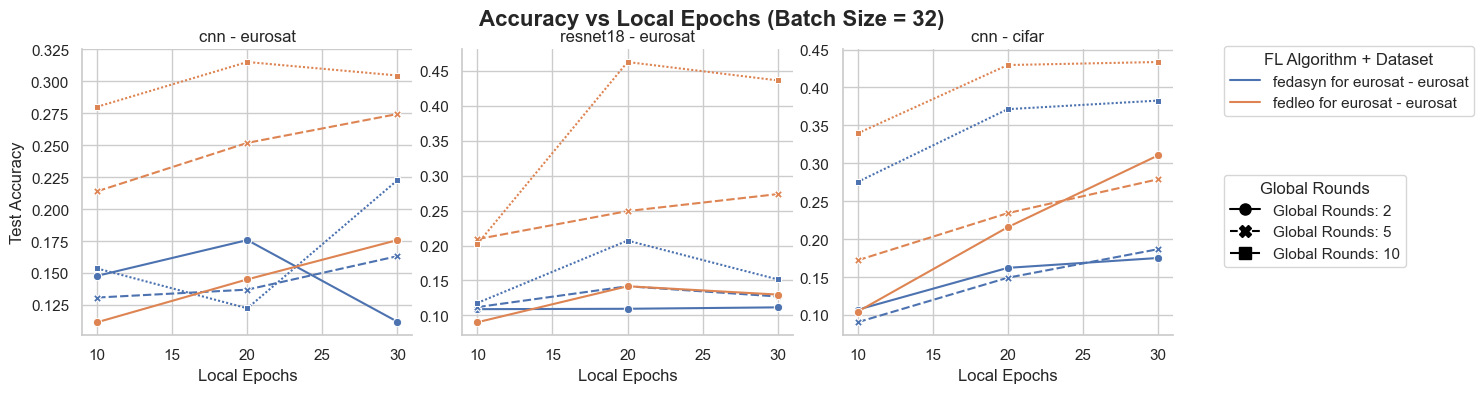

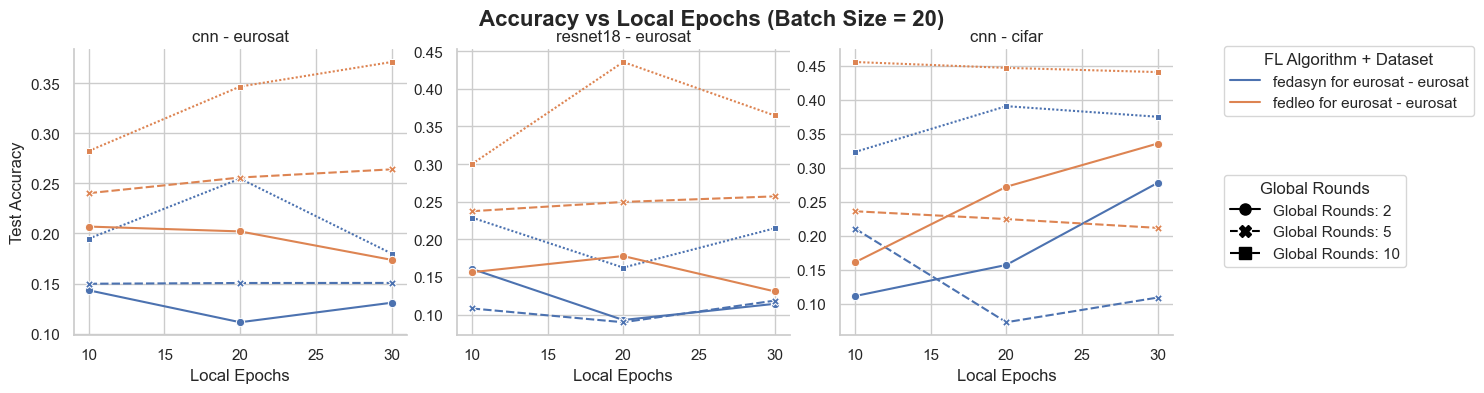

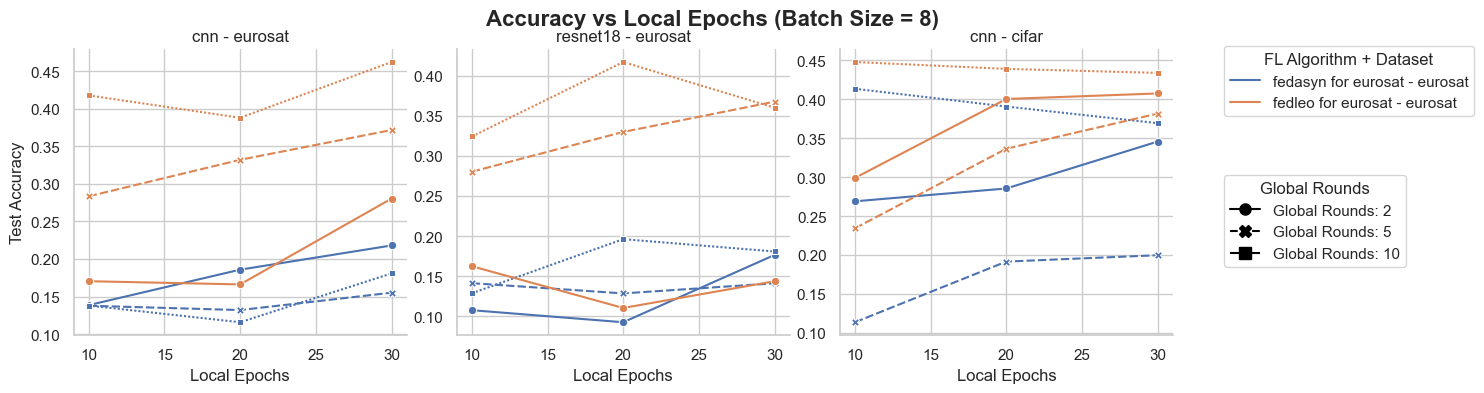

In [13]:
from matplotlib.lines import Line2D

# Clean once
df["Model"] = df["Model"].str.strip()
df["Dataset"] = df["Dataset"].str.strip()
df["Model Name"] = df["Model Name"].str.replace("fedasync", "fedasyn", case=False)
df["Model_Name_Clean"] = df["Model Name"].str.replace("fedasync", "fedasyn", case=False)

# Function to generate plot per batch size
def plot_accuracy_by_batch(df, batch_size):
    df_batch = df[df["Local Batch Size"] == batch_size].copy()
    df_batch["Facet"] = df_batch["Model"] + " - " + df_batch["Dataset"]
    df_batch["Model_Dataset_Name"] = df_batch["Model Name"] + " - " + df_batch["Dataset"]
    
    sns.set_theme(style="whitegrid")
    
    g = sns.FacetGrid(
        df_batch,
        col="Facet",
        height=4,
        aspect=1.2,
        sharey=False
    )

    g.map_dataframe(
        sns.lineplot,
        x="Local Epochs",
        y="Accuracy",
        hue="Model_Dataset_Name",
        style="Epochs",
        markers=True,
        dashes=True
    )

    # Get handles from first axis
    handles, labels = g.axes.flat[0].get_legend_handles_labels()
    unique_hues = df_batch["Model_Dataset_Name"].unique()
    hue_handles = [h for h, l in zip(handles, labels) if l in unique_hues]
    hue_labels = list(unique_hues)

    # Create style handles for Epochs
    epoch_styles = sorted(df_batch["Epochs"].unique())
    epoch_style_map = {
        2:  ('o', '-'),
        5:  ('X', '--'),
        10: ('s', '-.')
    }

    style_handles = [
        Line2D(
            [0], [0],
            linestyle=epoch_style_map[e][1],
            marker=epoch_style_map[e][0],
            markersize=8,
            markerfacecolor='black',
            markeredgecolor='black',
            color='black',
            label=f"Global Rounds: {e}"
        )
        for e in epoch_styles
    ]

    # Layout
    plt.subplots_adjust(top=0.88, right=0.82)
    g.set_titles("{col_name}")
    g.set_axis_labels("Local Epochs", "Test Accuracy")
    g.fig.suptitle(f"Accuracy vs Local Epochs (Batch Size = {batch_size})", fontsize=16, weight="bold")

    # Legends
    g.fig.legend(hue_handles, hue_labels, title="FL Algorithm + Dataset", loc='center left', bbox_to_anchor=(0.85, 0.8))
    g.fig.legend(style_handles, [f"Global Rounds: {e}" for e in epoch_styles], title="Global Rounds", loc='center left', bbox_to_anchor=(0.85, 0.45))

    plt.show()

# Call the function for batch sizes 32, 20, and 8
plot_accuracy_by_batch(df, 32)
plot_accuracy_by_batch(df, 20)
plot_accuracy_by_batch(df, 8)

### Average Accuracy by Local Epochs (Separated by Model)

This bar plot shows how average accuracy changes with different local training epochs (10, 20, 30) for two datasets (CIFAR10 and EuroSAT) using two FL algorithms: FedLEO and FedAsyn.

What it shows:
- FedLEO for CIFAR10 performs best overall. Accuracy improves clearly as local epochs increase — from ~27% at 10 epochs to ~36% at 30 epochs.

- FedAsyn for CIFAR10 also improves with more epochs, but not as much as FedLEO.

- FedLEO for EuroSAT improves steadily too, but at a slower pace compared to CIFAR10.

- FedAsyn for EuroSAT has the lowest accuracy and shows very little improvement, even as local epochs increase.

Increasing local epochs generally boosts accuracy, especially for FedLEO. FedLEO outperforms FedAsyn in both datasets, and the gap is more noticeable in the EuroSAT dataset, where FedAsyn struggles the most.



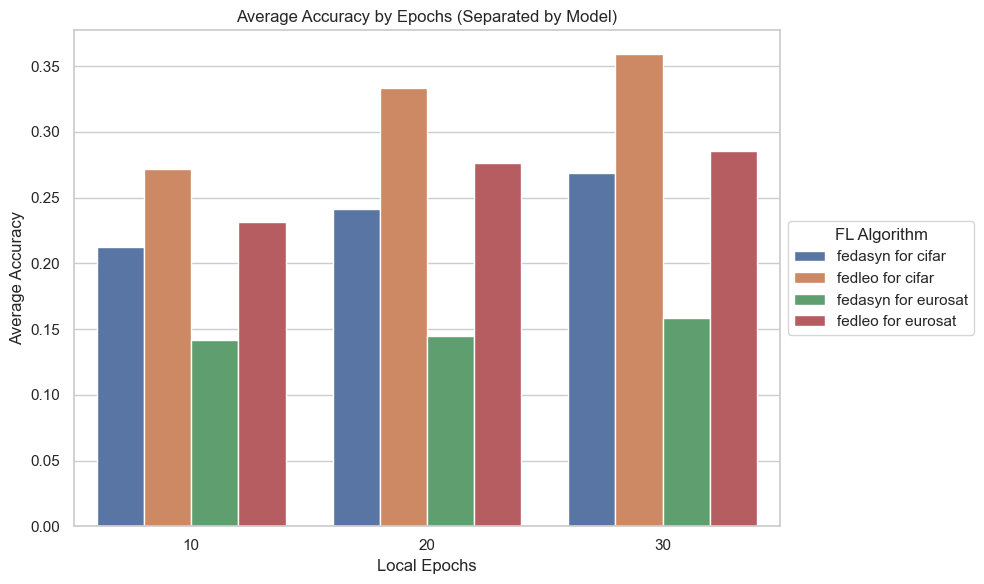

In [14]:
df_avg = df.groupby(["Local Epochs", "Dataset", "Model_Name_Clean"])["Accuracy"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_avg, x="Local Epochs", y="Accuracy", hue="Model_Name_Clean")
plt.title("Average Accuracy by Epochs (Separated by Model)")
plt.xlabel("Local Epochs")
plt.ylabel("Average Accuracy")
plt.legend(title="FL Algorithm", loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

### Average Accuracy vs Batch Size
This bar chart shows how batch size affects model accuracy for different combinations of datasets (CIFAR10 and EuroSAT) and FL algorithms (FedLEO and FedAsyn).

- Smaller batch sizes (8) give the best results overall.

  - FedLEO for CIFAR10 performs the best, reaching the highest accuracy at batch size 8.

  - FedAsyn for CIFAR10 and FedLEO for EuroSAT also perform well with batch size 8.

- As batch size increases to 20 and 32, accuracy drops across all models and algorithms.

- FedAsyn for EuroSAT performs the worst across all batch sizes, and its accuracy doesn't improve even with smaller batches.

Smaller batch sizes lead to better accuracy. FedLEO benefits the most, especially with CIFAR10. This shows that fine-grained updates (from smaller batches) help models learn better in federated learning setups.

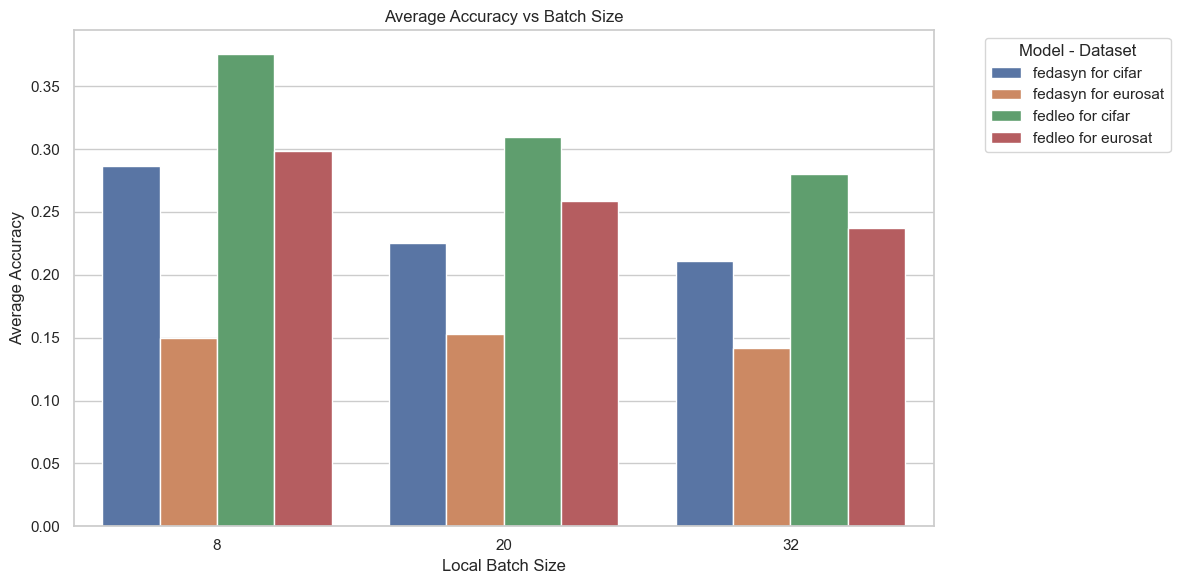

In [15]:
df_avg_batch = df.groupby(["Local Batch Size", "Model_Name_Clean"])["Accuracy"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=df_avg_batch, x="Local Batch Size", y="Accuracy", hue="Model_Name_Clean")
plt.title("Average Accuracy vs Batch Size")
plt.ylabel("Average Accuracy")
plt.legend(title="Model - Dataset", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


### Heatmap of Accuracy: Local Epochs vs Batch Size

This heatmap shows how accuracy changes when we vary both local epochs and batch size during training.

- Accuracy gets better with more local epochs:

  - At 10 epochs, accuracy is low.

  - At 30 epochs, accuracy is the highest (especially with batch size 8).

- Accuracy is best with batch size 8 across all epoch levels.

- The best accuracy (0.29) happens at 30 epochs and batch size 8.

- The worst accuracy (0.16) happens at 10 epochs and batch size 32.

To get the best performance, use more local epochs and smaller batch sizes. This combination helps the model learn more effectively in federated learning.

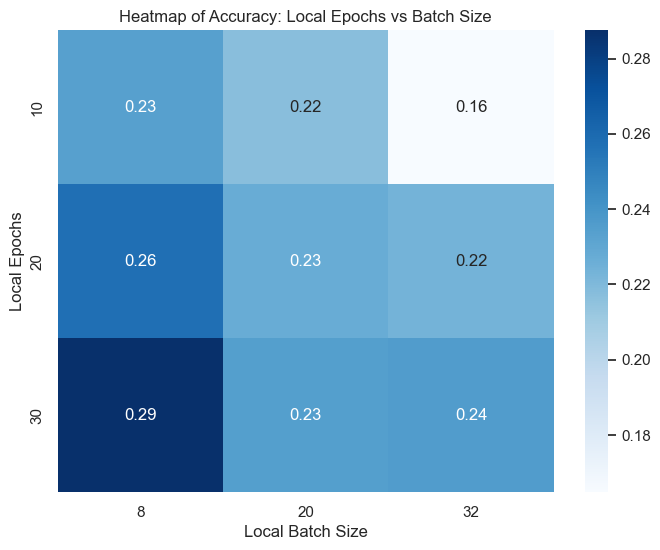

In [16]:
df_heatmap = df.groupby(["Local Epochs", "Local Batch Size"])["Accuracy"].mean().reset_index()
heatmap_data = df_heatmap.pivot(index="Local Epochs", columns="Local Batch Size", values="Accuracy")

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="Blues")
plt.title("Heatmap of Accuracy: Local Epochs vs Batch Size")
plt.show()

### Accuracy Distribution by FL Algorithm

This boxplot compares how well each FL algorithm performs across different settings by showing the range and spread of accuracy values.

- FedLEO for CIFAR has the highest accuracy overall and the most consistent results.

- FedAsyn for EuroSAT performs the worst, with the lowest accuracy and the smallest range, it struggles under these settings.

- FedAsyn for CIFAR and FedLEO for EuroSAT perform better than FedAsyn for EuroSAT but not as well as FedLEO for CIFAR.

FedLEO is more stable and accurate than FedAsyn, especially on the CIFAR dataset. This shows it is more reliable across different configurations.


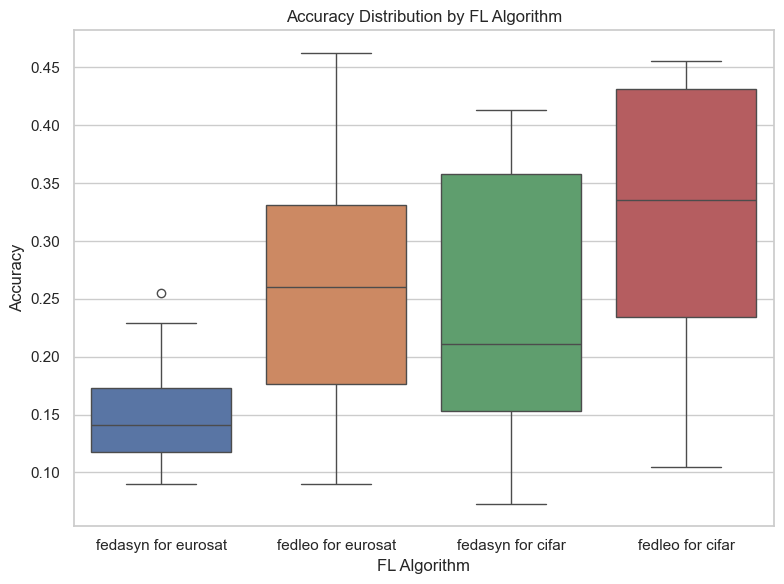

In [17]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="Model_Name_Clean", y="Accuracy", hue="Model_Name_Clean")
plt.title("Accuracy Distribution by FL Algorithm")
plt.xlabel("FL Algorithm")
plt.ylabel("Accuracy")
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()


### Accuracy by Data Distribution (IID vs non-IID)

This chart compares model accuracy under:

- IID (1) - means each client has similar data.

- non-IID (0) -means each client has different kinds of data.

Key observations:

 - FedLEO outperforms FedAsyn in both settings.

 - FedLEO for CIFAR achieves the highest accuracy with IID data.

 - FedAsyn struggles, especially with non-IID data.

 - FedLEO is more robust, making it better suited for real-world FL scenarios.

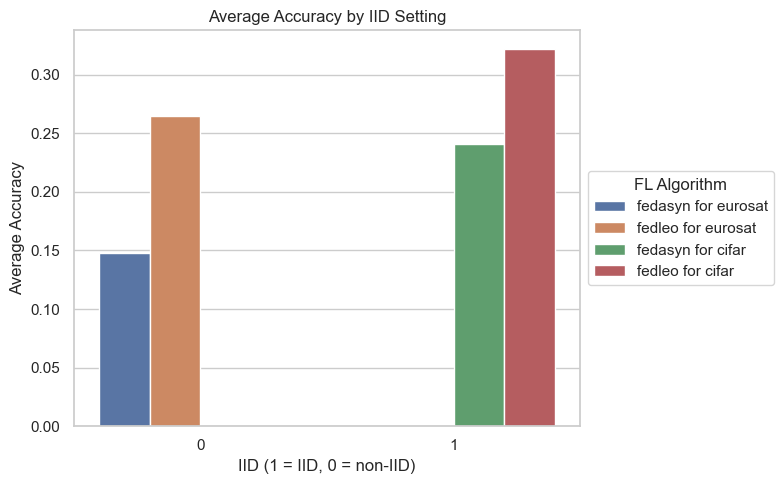

In [18]:
df_iid = df.groupby(["IID", "Model_Name_Clean"])["Accuracy"].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=df_iid, x="IID", y="Accuracy", hue="Model_Name_Clean")
plt.title("Average Accuracy by IID Setting")
plt.xlabel("IID (1 = IID, 0 = non-IID)")
plt.ylabel("Average Accuracy")
plt.legend(title="FL Algorithm", loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


### Accuracy vs Global Rounds (Faceted by Dataset)

This line plot shows how model accuracy improves as the number of global rounds (epochs) increases, shown separately for CIFAR10 and EuroSAT datasets.

- Key Points:
  - More global rounds = better accuracy for all models.

  - FedLEO clearly performs better than FedAsyn across both datasets.

  - FedLEO for CIFAR reaches the highest accuracy (~0.43) at 10 rounds.

  - FedAsyn for CIFAR improves slowly but stays behind FedLEO.

  - FedLEO for EuroSAT steadily improves with more rounds.

  - FedAsyn for EuroSAT shows very little improvement.

Increasing global rounds helps, and FedLEO consistently outperforms FedAsyn, especially as training progresses.

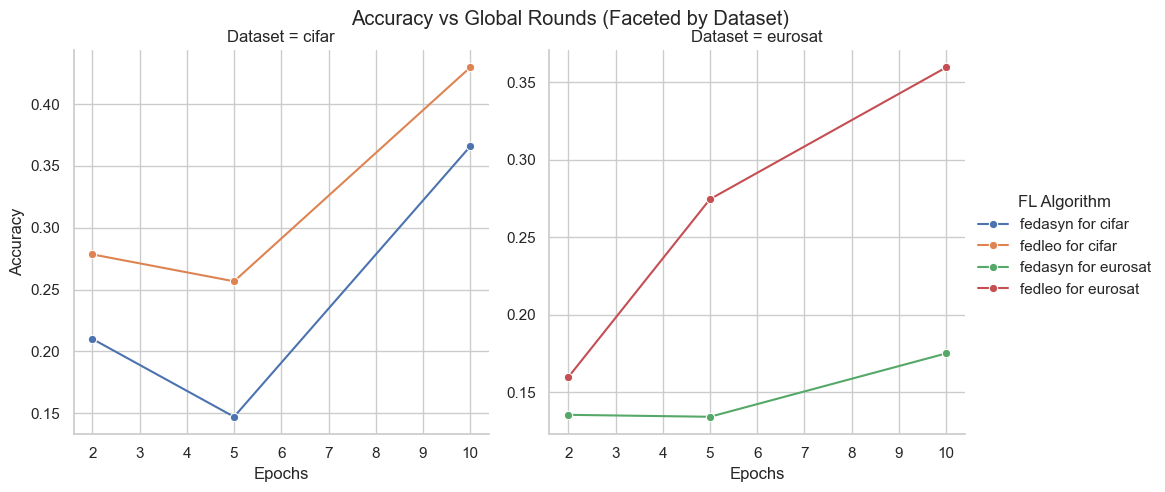

In [19]:
df_facet = df.groupby(["Epochs", "Dataset", "Model Name"])["Accuracy"].mean().reset_index()

g = sns.FacetGrid(df_facet, col="Dataset", hue="Model Name", sharey=False, col_wrap=2, height=5)
g.map(sns.lineplot, "Epochs", "Accuracy", marker="o")
g.add_legend(title="FL Algorithm")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Accuracy vs Global Rounds (Faceted by Dataset)")
plt.show()

## Heatmap – Accuracy per Model-Dataset

These three heatmaps show how accuracy changes with different combinations of local epochs and batch sizes, across different models and datasets.

- In all three heatmaps:

  - More local epochs lead to higher accuracy.

  - Smaller batch sizes (especially 8) consistently give the best performance.

- CNN on CIFAR10 shows the highest accuracy overall, reaching up to 0.36.

- CNN and ResNet18 on EuroSAT show similar patterns but with lower accuracy.

- Accuracy is lowest when using larger batch sizes (32) and fewer epochs (10).

Across all cases, the best results come from training longer and using smaller batch sizes, this improves model learning in federated setups.

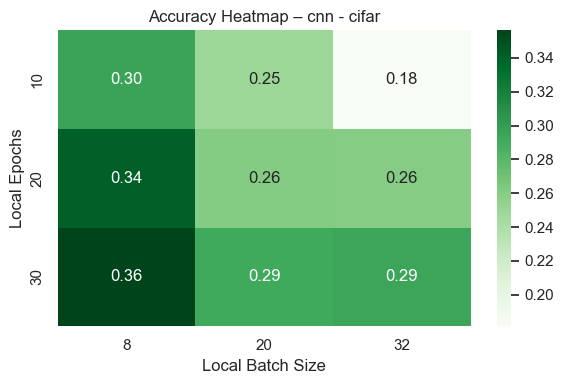

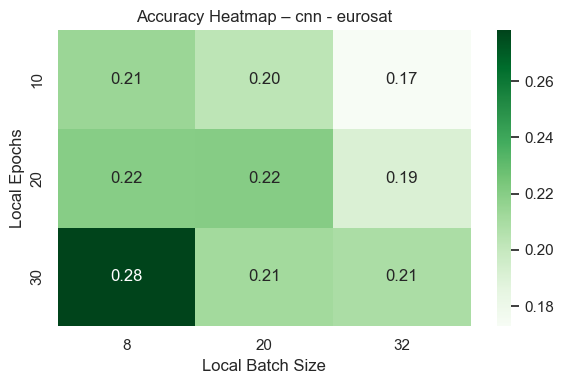

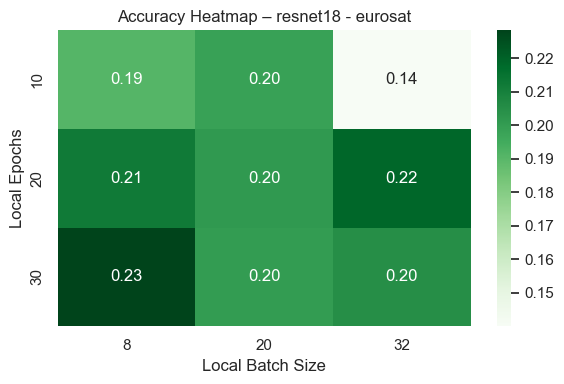

In [20]:
df["Model_Dataset"] = df["Model"].str.strip() + " - " + df["Dataset"].str.strip()

df_md_heatmap = df.groupby(["Model_Dataset", "Local Epochs", "Local Batch Size"])["Accuracy"].mean().reset_index()

for md in df_md_heatmap["Model_Dataset"].unique():
    data = df_md_heatmap[df_md_heatmap["Model_Dataset"] == md]
    heatmap_data = data.pivot(index="Local Epochs", columns="Local Batch Size", values="Accuracy")
    plt.figure(figsize=(6, 4))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="Greens")
    plt.title(f"Accuracy Heatmap – {md}")
    plt.tight_layout()
    plt.show()



### Full Experiment Runner (! Long Runtime !)

This code block runs **all combinations** of experiments for:

- **Models**: CNN, ResNet18  
- **Datasets**: EuroSAT (non-IID), CIFAR10 (IID)  
- **FL Algorithms**: FedLEO, FedAsyn  
- **Global Rounds**: 2, 5, 10  
- **Local Epochs**: 10, 20, 30  
- **Batch Sizes**: 8, 20, 32  

This results in **108 total runs** (3 experiments × 2 algorithms × 3 global rounds × 3 local epochs × 3 batch sizes).  
  - All output accuracies will be saved in **`accuracy_results.csv`**.

**Warning**: This loop takes a **very long time to complete**. It’s recommended to run experiments **in batches or one at a time** while testing or debugging.

---

##### Example – Run a Single Configuration:
You can manually run just one setup using the command below:
```bash
python src/federated_main.py --model cnn --dataset eurosat --iid 0 --epochs 10 --local_ep 30 --local_bs 8 --run fedleo


In [ ]:
# Experiment setups
experiments = [
    {"model": "cnn", "dataset": "eurosat", "iid": "0"},
    {"model": "resnet18", "dataset": "eurosat", "iid": "0"},
    {"model": "cnn", "dataset": "cifar", "iid": "1"},
]

# Federated learning algorithms
algorithms = ["fedleo", "fedasync"]

# Parameters to explore
global_epochs = ["2", "5", "10"]
local_epochs = ["10", "20", "30"]
batch_sizes = ["8", "20", "32"]


In [ ]:
# This cell executes training for all combinations
for exp in experiments:
    for alg in algorithms:
        for ge in global_epochs:
            for le in local_epochs:
                for bs in batch_sizes:
                    print(f"Running {alg} | Model: {exp['model']} | Dataset: {exp['dataset']} | Epochs: {ge} | Local Epochs: {le} | BS: {bs}")
                    
                    subprocess.run([
                        "python", "src/federated_main.py",
                        "--model", exp["model"],
                        "--dataset", exp["dataset"],
                        "--iid", exp["iid"],
                        "--epochs", ge,
                        "--local_ep", le,
                        "--local_bs", bs,
                        "--run", alg
                    ])
